In [32]:
import pandas as pd
import bioframe as bf
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [33]:
# Load TSA-seq data. These are processed files from the Belmont lab.

son_tsa_seq_rep1 = "../../shared/4DNFI8HIU45G.bw"
son_tsa_seq_rep2 = "../../shared/4DNFIBY8G6RZ.bw"

In [34]:
# bioframe has functions which can be used to get chromosome names and sizes etc

hg38 = bf.assembly_info("hg38")

#hg38.chromnames, hg38.chromsizes

In [35]:
#import the bigWig into a DataFrame

son_tsa_seq_rep1_bf = pd.concat([bf.read_bigwig(son_tsa_seq_rep1, chrom, engine='pyBigWig') for chrom in hg38.chromnames[:24]], axis=0)
son_tsa_seq_rep2_bf = pd.concat([bf.read_bigwig(son_tsa_seq_rep2, chrom, engine='pyBigWig') for chrom in hg38.chromnames[:24]], axis=0)
son_tsa_seq_rep1_bf

,chrom,start,end,value
0,chr1,9999,29999,1.172047
1,chr1,29999,49999,0.965637
2,chr1,49999,69999,0.477285
3,chr1,69999,89999,0.261049
4,chr1,89999,109999,0.625390
...,...,...,...,...
2856,chrY,57129999,57149999,0.266407
2857,chrY,57149999,57169999,0.311495
2858,chrY,57169999,57189999,0.514128
2859,chrY,57189999,57209999,0.960278


In [36]:
# Instead of using genes as our viewpoint,we can create equally sized bins, each 100kb

hg38_100k_bins = bf.binnify(hg38.chromsizes, 10**5)
hg38_100k_bins['name'] = hg38_100k_bins.index

In [37]:
hg38_100k_bins

,chrom,start,end,name
0,chr1,0,100000,0
1,chr1,100000,200000,1
2,chr1,200000,300000,2
3,chr1,300000,400000,3
4,chr1,400000,500000,4
...,...,...,...,...
30890,chrY,56900000,57000000,30890
30891,chrY,57000000,57100000,30891
30892,chrY,57100000,57200000,30892
30893,chrY,57200000,57227415,30893


In [38]:
#add the information from TSA-seq to each bin

overlap1 = bf.overlap(hg38_100k_bins,son_tsa_seq_rep1_bf).groupby('name').mean('value_')
overlap2 = bf.overlap(hg38_100k_bins,son_tsa_seq_rep2_bf).groupby('name').mean('value_')

hg38_100k_bins_coordinates = pd.merge(hg38_100k_bins,
             overlap1[['value_']].rename(columns={'value_':'SON_TSA_rep1'}),
                                    how='left',
                                    on='name'
                                   )

hg38_100k_bins_coordinates = pd.merge(hg38_100k_bins_coordinates,
             overlap2[['value_']].rename(columns={'value_':'SON_TSA_rep2'}),
                                    how='left',
                                    on='name'
                                   )

hg38_100k_bins_coordinates['son_average_dist'] = (hg38_100k_bins_coordinates.SON_TSA_rep1 + hg38_100k_bins_coordinates.SON_TSA_rep2)/2
hg38_100k_bins_coordinates['exp_SON_TSA_rep1'] = np.exp(-hg38_100k_bins_coordinates.SON_TSA_rep1)
hg38_100k_bins_coordinates['exp_SON_TSA_rep2'] = np.exp(-hg38_100k_bins_coordinates.SON_TSA_rep2)
hg38_100k_bins_coordinates['exp_son_average_dist'] = np.exp(-hg38_100k_bins_coordinates.son_average_dist)

In [39]:
hg38_100k_bins_coordinates

,chrom,start,end,name,SON_TSA_rep1,SON_TSA_rep2,son_average_dist,exp_SON_TSA_rep1,exp_SON_TSA_rep2,exp_son_average_dist
0,chr1,0,100000,0,0.700282,0.597582,0.648932,0.496445,0.550140,0.522604
1,chr1,100000,200000,1,0.778277,0.709748,0.744013,0.459196,0.491768,0.475203
2,chr1,200000,300000,2,0.604960,0.491452,0.548206,0.546097,0.611737,0.577986
3,chr1,300000,400000,3,0.483411,0.382257,0.432834,0.616676,0.682320,0.648668
4,chr1,400000,500000,4,0.549782,0.503641,0.526711,0.577076,0.604326,0.590544
...,...,...,...,...,...,...,...,...,...,...
30890,chrY,56900000,57000000,30890,0.071650,0.042526,0.057088,0.930856,0.958366,0.944511
30891,chrY,57000000,57100000,30891,0.169476,0.110749,0.140112,0.844107,0.895164,0.869261
30892,chrY,57100000,57200000,30892,0.454588,0.186412,0.320500,0.634709,0.829931,0.725786
30893,chrY,57200000,57227415,30893,1.104466,0.945276,1.024871,0.331388,0.388572,0.358843


In [ ]:
# load count table (output from DESeq2 analysis - bins analysis)

counts_SONdepl = pd.read_csv('../data/bins_SONd_vs_control_res_LFC.csv', index_col=0)
counts_SRRM2depl = pd.read_csv('../data/bins_SRRM2d_vs_control_res_LFC.csv', index_col=0)
counts_doubledepl = pd.read_csv('../data/bins_double_vs_control_res_LFC.csv', index_col=0)
counts_doubledepl

,baseMean,log2FoldChange,lfcSE,pvalue,padj
bin_24884,607.940199,-1.702741,0.167455,1.957373e-25,5.769554e-21
bin_24903,599.042181,-1.739515,0.173792,9.680901e-25,1.055496e-20
bin_24904,568.818860,-1.827879,0.182838,1.074260e-24,1.055496e-20
bin_24905,518.924286,-1.811215,0.185271,9.738422e-24,7.176243e-20
bin_17999,562.329257,-1.867607,0.193095,2.660795e-23,1.568592e-19
...,...,...,...,...,...
bin_13666,951.990953,-0.000069,0.076274,9.986253e-01,9.987609e-01
bin_17343,989.828075,-0.000003,0.074102,9.992549e-01,9.993566e-01
bin_7170,890.577207,0.000026,0.079920,9.995126e-01,9.995804e-01
bin_7808,1079.024074,0.000054,0.063011,9.995978e-01,9.996318e-01


In [41]:
#double-depletion vs control
counts_doubledepl.index.name = 'name'
counts_doubledepl.reset_index(inplace=True)
counts_doubledepl = counts_doubledepl[["name", "log2FoldChange", "padj"]].rename(columns={"log2FoldChange": "H3K9me3_diff"})

#son-depletion vs control
counts_SONdepl.index.name = 'name'
counts_SONdepl.reset_index(inplace=True)
counts_SONdepl = counts_SONdepl[["name", "log2FoldChange", "padj"]].rename(columns={"log2FoldChange": "H3K9me3_diff"})

#srrm2-depletion vs control
counts_SRRM2depl.index.name = 'name'
counts_SRRM2depl.reset_index(inplace=True)
counts_SRRM2depl = counts_SRRM2depl[["name", "log2FoldChange", "padj"]].rename(columns={"log2FoldChange": "H3K9me3_diff"})

counts_SRRM2depl

,name,H3K9me3_diff,padj
0,bin_7380,-0.859591,0.000062
1,bin_23768,-0.646947,0.000130
2,bin_26563,-0.897600,0.000130
3,bin_11404,-0.636609,0.000130
4,bin_20459,-0.984409,0.000187
...,...,...,...
29476,bin_14672,0.000055,0.999225
29477,bin_29392,0.000174,0.999271
29478,bin_25631,-0.000004,0.999430
29479,bin_11516,0.000024,0.999538


In [42]:
# Extract the number after "bin_"

#double-depletion vs control
counts_doubledepl['name'] = counts_doubledepl['name'].str.extract(r'bin_(\d+)')
counts_doubledepl['name'] = counts_doubledepl['name'].astype(int)

#son-depletion vs control
counts_SONdepl['name'] = counts_SONdepl['name'].str.extract(r'bin_(\d+)')
counts_SONdepl['name'] = counts_SONdepl['name'].astype(int)


#srrm2-depletion vs control
counts_SRRM2depl['name'] = counts_SRRM2depl['name'].str.extract(r'bin_(\d+)')
counts_SRRM2depl['name'] = counts_SRRM2depl['name'].astype(int)
counts_SRRM2depl

,name,H3K9me3_diff,padj
0,7380,-0.859591,0.000062
1,23768,-0.646947,0.000130
2,26563,-0.897600,0.000130
3,11404,-0.636609,0.000130
4,20459,-0.984409,0.000187
...,...,...,...
29476,14672,0.000055,0.999225
29477,29392,0.000174,0.999271
29478,25631,-0.000004,0.999430
29479,11516,0.000024,0.999538


In [43]:
#merge the deseq counts with the information about the bins

counts_doubledepl = pd.merge(hg38_100k_bins,
            counts_doubledepl,
              on='name',
            how='left'
            )

counts_SONdepl = pd.merge(hg38_100k_bins,
            counts_SONdepl,
              on='name',
            how='left'
            )

counts_SRRM2depl = pd.merge(hg38_100k_bins,
            counts_SRRM2depl,
              on='name',
            how='left'
            )
counts_SRRM2depl

,chrom,start,end,name,H3K9me3_diff,padj
0,chr1,0,100000,0,-0.002980,0.973130
1,chr1,100000,200000,1,-0.252375,0.049115
2,chr1,200000,300000,2,-0.140084,0.173348
3,chr1,300000,400000,3,-0.039808,0.732832
4,chr1,400000,500000,4,-0.094909,0.310687
...,...,...,...,...,...,...
30890,chrY,56900000,57000000,30890,-0.012401,0.917942
30891,chrY,57000000,57100000,30891,0.159394,0.152550
30892,chrY,57100000,57200000,30892,0.147799,0.153926
30893,chrY,57200000,57227415,30893,-0.207479,0.142362


In [44]:
# calculate the average distance of each bin to speckles (SON)

#double-depletion vs control

overlap1 = bf.overlap(counts_doubledepl,son_tsa_seq_rep1_bf).groupby('name').mean('value_')
overlap2 = bf.overlap(counts_doubledepl,son_tsa_seq_rep2_bf).groupby('name').mean('value_')

double_coordinates = pd.merge(counts_doubledepl,
             overlap1[['value_']].rename(columns={'value_':'SON_TSA_rep1'}),
                                    how='left',
                                    on='name'
                                   )

double_coordinates = pd.merge(double_coordinates,
             overlap2[['value_']].rename(columns={'value_':'SON_TSA_rep2'}),
                                    how='left',
                                    on='name'
                                   )

double_coordinates['son_average_dist'] = (double_coordinates.SON_TSA_rep1 + double_coordinates.SON_TSA_rep2)/2
double_coordinates['exp_SON_TSA_rep1'] = np.exp(-double_coordinates.SON_TSA_rep1)
double_coordinates['exp_SON_TSA_rep2'] = np.exp(-double_coordinates.SON_TSA_rep2)
double_coordinates['exp_son_average_dist'] = np.exp(-double_coordinates.son_average_dist)


#SON-depletion vs control

overlap1 = bf.overlap(counts_SONdepl,son_tsa_seq_rep1_bf).groupby('name').mean('value_')
overlap2 = bf.overlap(counts_SONdepl,son_tsa_seq_rep2_bf).groupby('name').mean('value_')

son_coordinates = pd.merge(counts_SONdepl,
             overlap1[['value_']].rename(columns={'value_':'SON_TSA_rep1'}),
                                    how='left',
                                    on='name'
                                   )

son_coordinates = pd.merge(son_coordinates,
             overlap2[['value_']].rename(columns={'value_':'SON_TSA_rep2'}),
                                    how='left',
                                    on='name'
                                   )

son_coordinates['son_average_dist'] = (son_coordinates.SON_TSA_rep1 + son_coordinates.SON_TSA_rep2)/2
son_coordinates['exp_SON_TSA_rep1'] = np.exp(-son_coordinates.SON_TSA_rep1)
son_coordinates['exp_SON_TSA_rep2'] = np.exp(-son_coordinates.SON_TSA_rep2)
son_coordinates['exp_son_average_dist'] = np.exp(-son_coordinates.son_average_dist)


#SRRM2-depletion vs control

overlap1 = bf.overlap(counts_SRRM2depl,son_tsa_seq_rep1_bf).groupby('name').mean('value_')
overlap2 = bf.overlap(counts_SRRM2depl,son_tsa_seq_rep2_bf).groupby('name').mean('value_')

srrm2_coordinates = pd.merge(counts_SRRM2depl,
             overlap1[['value_']].rename(columns={'value_':'SON_TSA_rep1'}),
                                    how='left',
                                    on='name'
                                   )

srrm2_coordinates = pd.merge(srrm2_coordinates,
             overlap2[['value_']].rename(columns={'value_':'SON_TSA_rep2'}),
                                    how='left',
                                    on='name'
                                   )

srrm2_coordinates['son_average_dist'] = (srrm2_coordinates.SON_TSA_rep1 + srrm2_coordinates.SON_TSA_rep2)/2
srrm2_coordinates['exp_SON_TSA_rep1'] = np.exp(-srrm2_coordinates.SON_TSA_rep1)
srrm2_coordinates['exp_SON_TSA_rep2'] = np.exp(-srrm2_coordinates.SON_TSA_rep2)
srrm2_coordinates['exp_son_average_dist'] = np.exp(-srrm2_coordinates.son_average_dist)

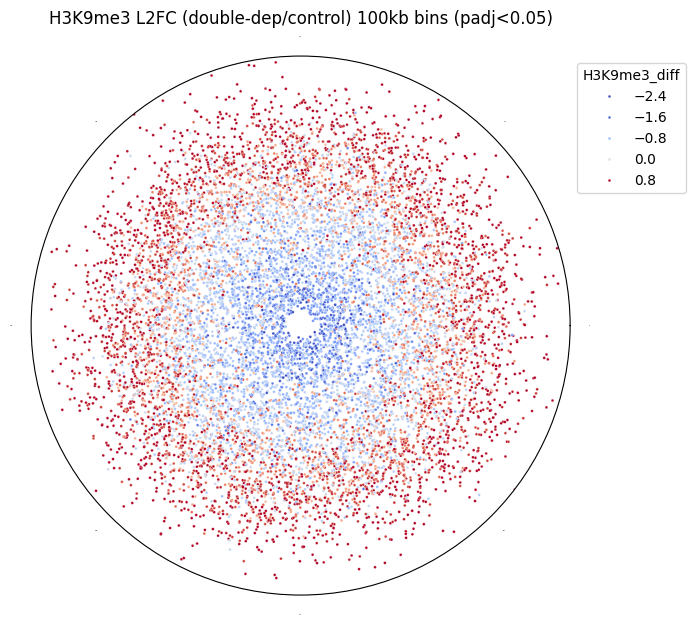

In [45]:
#plot double-depletion vs control

fig, axs = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection': 'polar'}, figsize=[14,7])

temp =double_coordinates.dropna().query("padj < 0.05").sample(frac=0.5, random_state=42)

rng = np.random.default_rng(seed=42)
theta = rng.random(len(temp))*2*np.pi

ax1=sns.scatterplot(x=theta,
                    y=temp.exp_son_average_dist,
                    s=4,
                    hue=temp.H3K9me3_diff,
                    hue_norm=mpl.colors.TwoSlopeNorm(vmin=-1.8, vcenter=0,  vmax=0.5),
                    palette='coolwarm',
                    rasterized=True
               )


ax1.set_title("H3K9me3 L2FC (double-dep/control) 100kb bins (padj<0.05)", va='bottom')


ax1.set_rticks([])  
ax1.set_ylabel('')
sns.move_legend(ax1, "upper left", bbox_to_anchor=(1, 1))
ax1.grid(False)
ax1.set_ylabel('')
ax1.tick_params(labelsize=0, width=0)
ax1.set_rmax(2.5)
plt.show()
plt.close()

plt.rcParams['pdf.fonttype'] = 42
fig.savefig('../data/DoublevsControl_radial.pdf', dpi=300, bbox_inches='tight') 

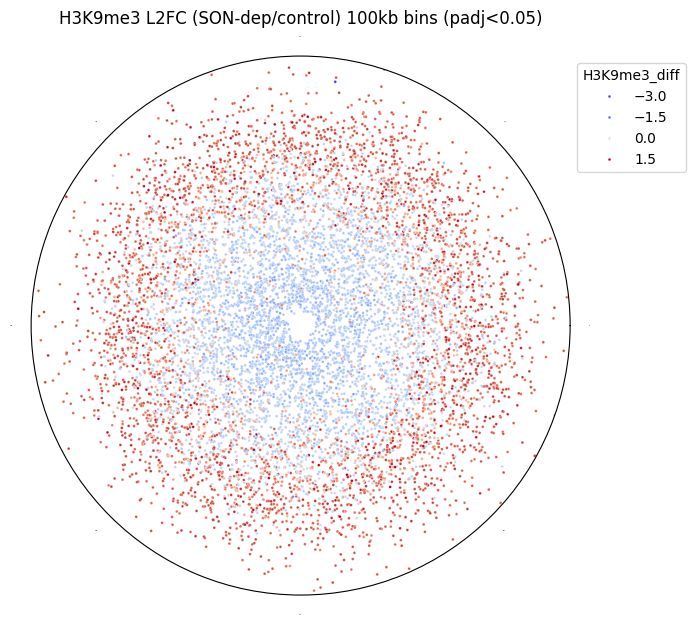

In [46]:
#plot SON-depletion vs control

fig, axs = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection': 'polar'}, figsize=[14,7])

temp =son_coordinates.dropna().query("padj < 0.05").sample(frac=0.5, random_state=42)

rng = np.random.default_rng(seed=42)
theta = rng.random(len(temp))*2*np.pi

ax1=sns.scatterplot(x=theta,
                    y=temp.exp_son_average_dist,
                    s=4,
                    hue=temp.H3K9me3_diff,
                    hue_norm=mpl.colors.TwoSlopeNorm(vmin=-1.8, vcenter=0,  vmax=0.5),
                    palette='coolwarm',
                    rasterized=True
               )


ax1.set_title("H3K9me3 L2FC (SON-dep/control) 100kb bins (padj<0.05)", va='bottom')


ax1.set_rticks([])  
ax1.set_ylabel('')
sns.move_legend(ax1, "upper left", bbox_to_anchor=(1, 1))
ax1.grid(False)
ax1.set_ylabel('')
ax1.tick_params(labelsize=0, width=0)
ax1.set_rmax(2.5)
plt.show()
plt.close()

plt.rcParams['pdf.fonttype'] = 42
fig.savefig('../data/SONvsControl_radial.pdf', dpi=300, bbox_inches='tight') 

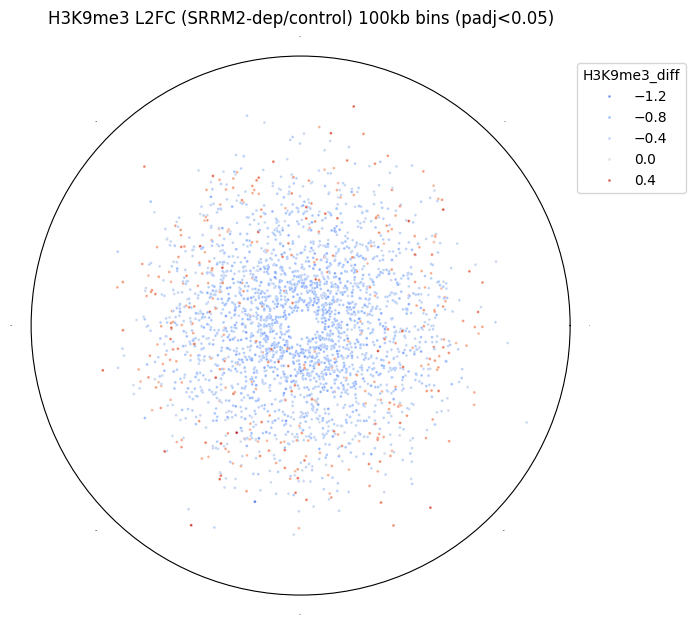

In [47]:
#plot SRRM2-depletion vs control

fig, axs = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection': 'polar'}, figsize=[14,7])

temp =srrm2_coordinates.dropna().query("padj < 0.05").sample(frac=0.5, random_state=42)

rng = np.random.default_rng(seed=42)
theta = rng.random(len(temp))*2*np.pi

ax1=sns.scatterplot(x=theta,
                    y=temp.exp_son_average_dist,
                    s=4,
                    hue=temp.H3K9me3_diff,
                    hue_norm=mpl.colors.TwoSlopeNorm(vmin=-1.8, vcenter=0,  vmax=0.5),
                    palette='coolwarm',
                    rasterized=True
               )


ax1.set_title("H3K9me3 L2FC (SRRM2-dep/control) 100kb bins (padj<0.05)", va='bottom')


ax1.set_rticks([])  
ax1.set_ylabel('')
sns.move_legend(ax1, "upper left", bbox_to_anchor=(1, 1))
ax1.grid(False)
ax1.set_ylabel('')
ax1.tick_params(labelsize=0, width=0)
ax1.set_rmax(2.5)
plt.show()
plt.close()

plt.rcParams['pdf.fonttype'] = 42
fig.savefig('../data/SRRM2vsControl_radial.pdf', dpi=300, bbox_inches='tight') 